In [24]:
using Gen, Plots, LinearAlgebra

In [28]:
function getRotationMatrix(theta::Float64)
    return [cos(theta) -sin(theta); sin(theta) cos(theta)]
end

getRotationMatrix (generic function with 1 method)

In [42]:
function isInBox(box::Matrix{Float64}, point::Vector{Float64}, x::Float64)
    return box[1]
    # AB = [box[1][2]-box[1][1];box[2][2]-box[2][1]]
    # BC = [box[1][3]-box[1][2];box[2][3]-box[2][2]]
    # CD = [box[1][4]-box[1][3];box[2][4]-box[2][3]]
    # DA = [box[1][1]-box[1][3];box[2][1]-box[2][3]]

    # ABn = [box[5][1]; box[5][2]]
    # BCn = [box[6][1]; box[6][2]]
    # CDn = [box[7][1]; box[7][2]]
    # DAn = [box[8][1]; box[8][2]]

    # ABm = 0.0
    # BCm = 0.0
    # CDm = 0.0
    # DAm = 0.0

    # if AB[1] != 0.0
    #     ABm = AB[2]/AB[1]
    # end
    # if BC[1] != 0.0
    #     BCm = BC[2]/BC[1]
    # end
    # if CD[1] != 0.0
    #     CDm = CD[2]/CD[1]
    # end
    # if DA[1] != 0.0
    #     DAm = DA[2]/DA[1]
    # end

    # ABb = AB[2] - ABm * AB[1]
    # BCb = BC[2] - BCm * BC[1]
    # CDb = CD[2] - CDm * CD[1]
    # DAb = DA[2] - DAm * DA[1]

    # return f1(x) = ABm * x + ABb
        
    # return box
    # return 1.0
end

isInBox (generic function with 3 methods)

In [60]:
function getIntersectionTime()
end

getIntersectionTime (generic function with 1 method)

In [54]:
box = getRotationMatrix(0.0) * [1 -1 -1 1; 1 1 -1 -1]
point = [-0.5; 0]
x = 1.0
isInBox(box, point, x)
box


2×4 Matrix{Float64}:
 1.0  -1.0  -1.0   1.0
 1.0   1.0  -1.0  -1.0

In [59]:
box[8]

-1.0

Jittering is done by the method 3 of first gen tutorial (posterior inference)

In [23]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int, theta::Float64)
    box = [1 -1 -1 1 0 -1 0 1;
            1 1 -1 -1 1 0 -1 0]   # A B C D AB_norm BC_norm CD_norm DA_norm
    rotation_matrix = getRotationMatrix(theta)
    box = rotation_matrix * box
    
    
    measurement_noise = 0.005
    velocity_var = 1e-6

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = {:x0} ~ normal(0.01, 0.01)

    # prior on initial y-coordinate
    y = {:y0} ~ normal(0.95, 0.01)

    # prior on x-component of initial velocity
    vx = {:vx0} ~ normal(0.002, 0.01)

    # prior on y-component of initial velocity
    vy = {:vy0} ~ normal(-0.013, 0.01)

    # initial bearing measurement
    z0 ~ normal(bearing(x, y), measurement_noise)

    # record position
    xs[1] = x
    ys[1] = y

    # generate successive states and measurements
    for t=1:T

        # update the state of the point
        vx = {(:vx, t)} ~ normal(vx, sqrt(velocity_var))
        vy = {(:vy, t)} ~ normal(vy, sqrt(velocity_var))
        x += vx
        y += vy

        # bearing measurement
        {(:z, t)} ~ normal(bearing(x, y), measurement_noise)

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end

    # return the sequence of positions
    return (xs, ys)
end;

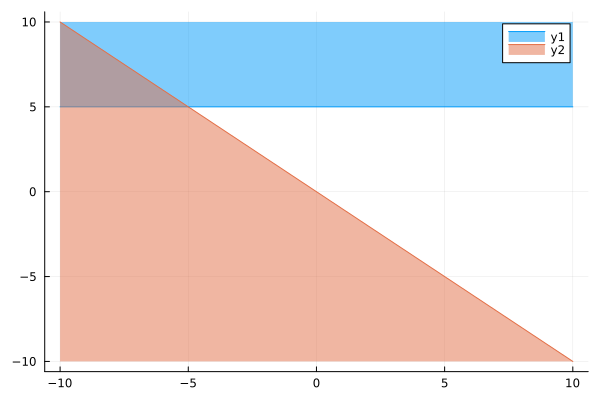

In [74]:
using Plots
f(x) = 5
g(x) = -x
X = -10:10
the_max = max(f(X[end]), g(X[1]))
the_min = min(f(X[1]), g(X[end]))
plot(X, f, fill = (the_max, 0.5, :auto))
plot!(X, g, fill = (the_min, 0.5, :auto))


In [67]:
using ImplicitEquations, Plots
f(x,y) = 2x - 5y - 6
g(x,y) = x + y - 0
plot((f < 0) & (g > 0))

LoadError: ArgumentError: Package ImplicitEquations not found in current path.
- Run `import Pkg; Pkg.add("ImplicitEquations")` to install the ImplicitEquations package.